# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [3]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
# 使用一个有效的 matplotlib 样式，而不是直接使用 'seaborn'
try:
    plt.style.use('seaborn-v0_8')  # 新版本 matplotlib 中的 seaborn 兼容样式
except:
    # 如果上面的失败，尝试简单设置
    sns.set()  # 让 seaborn 设置其默认样式

%matplotlib inline

In [4]:
# show os path
print(os.path.realpath('.'))

/Users/macbook/Documents/ucsf_couses/ds223/assignments/4-it-s-about-time-Exynos-8890


## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [5]:
timestamp = pd.read_csv('data/S1/Final/TEMP.csv', sep=',',nrows = 1,header=None).iloc[0,0]
interval = pd.read_csv('data/S1/Final/TEMP.csv', sep=',',nrows = 2,skiprows=1, header=None).iloc[0,0]
print('timestamp:', timestamp, 'interval:', interval)
df = pd.read_csv('data/S1/Final/TEMP.csv', sep=',',skiprows=2, header=None)
df.head()

timestamp: 1544027337.0 interval: 4.0


,0
0,21.89
1,21.89
2,21.89
3,21.89
4,21.89


In [37]:
def load_data(data_dir='data/'):
    """Load and organize the physiological data from the dataset.
    
    Parameters
    ----------
    data_dir : str
        Path to the directory containing the dataset files
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing the organized physiological data with columns:
        ['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session']
    """
    file_dict = {
        'heart_rate': 'HR.csv',
        'eda': 'EDA.csv',
        'temperature': 'TEMP.csv'
    }
    data_dir = os.path.join(os.getcwd(), data_dir)
    data_dir = Path(data_dir)
    dir_list = os.listdir(data_dir)
    dir_list.sort()
    data = pd.DataFrame(columns=['timestamp', 'heart_rate', 'eda', 'temperature', 'subject_id', 'session'])
    for patient_folder in dir_list:
        if not os.path.isdir(os.path.join(data_dir, patient_folder)): continue
        # print(f"Processing folder: {patient_folder}")
        patient_path = os.path.join(data_dir, patient_folder)
        exam_folder = os.listdir(patient_path)
        exam_folder.sort()
        for exam in exam_folder:
            if not os.path.isdir(os.path.join(patient_path, exam)): continue
            # print(f"    Processing exam: {exam}")
            exam_path = os.path.join(patient_path, exam)
            for column_name, file_name in file_dict.items():
                file_path = os.path.join(exam_path, file_name)
                # print(f"        Processing file: {file_name}")
                if not os.path.exists(file_path):
                    print(f"        File {file_name} not found in {exam_path}")
                    continue
                timestamp = pd.read_csv(file_path, sep=',',nrows = 1,header=None).iloc[0,0].astype(float)
                sample_rate = pd.read_csv(file_path, sep=',',nrows = 2,skiprows=1, header=None).iloc[0,0].astype(float)
                df = pd.read_csv(file_path, sep=',',skiprows=2, header=None,names = [column_name])
                # check if the file is empty
                if df.empty:
                    print(f"        File {file_name} is empty in {exam_path}")
                    continue
                df['timestamp'] = df.index / sample_rate + timestamp
                df['subject_id'] = patient_folder
                df['session'] = exam
                data = pd.concat([data, df], ignore_index=True)
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
    data = data.pivot_table(
        index=['timestamp', 'subject_id', 'session'],
        values=['heart_rate', 'eda', 'temperature'],
        aggfunc='first'
    )
    data = data.rename(columns={'timestamp': 'timestamp', 'heart_rate': 'heart_rate', 'eda': 'eda', 'temperature': 'temperature'}).reset_index().set_index('timestamp')
    return data

data = load_data()
            
# why ther is warning
    

/var/folders/p5/yfgnjpp168b0_wgd4j025sj00000gn/T/ipykernel_95744/3729881658.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, df], ignore_index=True)
/var/folders/p5/yfgnjpp168b0_wgd4j025sj00000gn/T/ipykernel_95744/3729881658.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, df], ignore_index=True)
/var/folders/p5/yfgnjpp168b0_wgd4j025sj00000gn/T/ipykernel_95744/3729881658.py:51: FutureWarning: The behavior of DataFrame concatenation with emp

## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [74]:
def preprocess_data(data, output_dir='data/processed'):
    """Clean and prepare the physiological data for analysis.
    
    Parameters
    ----------
    data : pd.DataFrame
        Raw physiological data
    output_dir : str
        Directory to save processed data files
        
    Returns
    -------
    pd.DataFrame
        Cleaned and preprocessed data
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Your code here
    # 1. Handle missing values
    data = data.ffill()
    # 2. Resample to regular intervals
    data = data.groupby(['subject_id','session']).resample('.25s').mean().interpolate(method='linear').reset_index().set_index('timestamp')
    # 3. Remove outliers (z-score > 3)
    z_scores = np.abs(stats.zscore(data[['heart_rate', 'eda', 'temperature']]))
    data = data[(z_scores < 3).all(axis=1)]
    # 4. Save processed data to CSV files
    # cd ..
    
    os.makedirs(output_dir, exist_ok=True)
    for subject_id, group in data.groupby('subject_id'):
        subject_data = group.drop(columns=['subject_id'])
        path = os.path.join(output_dir, f'{subject_id}_processed.csv')
        subject_data.to_csv(path, index=True)
    
    return data

data_preprocessed = preprocess_data(data)
    


## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

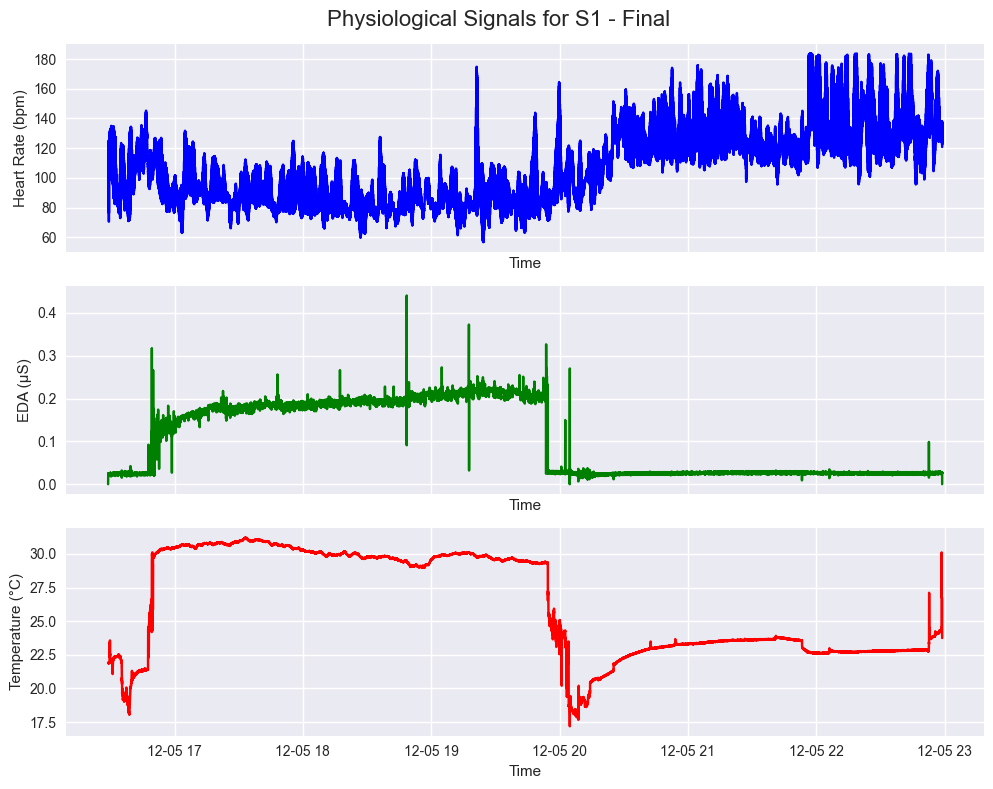

In [81]:
def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """Create plots of physiological signals for a given subject and session.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    subject_id : str
        Subject identifier (e.g., 'S1')
    session : str
        Session identifier (e.g., 'Midterm 1')
    output_dir : str
        Directory to save plot files
        
    Returns
    -------
    matplotlib.figure.Figure
        Figure object containing the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Your code here
    session_unique = data['session'].unique()
    subject_id_unique = data['subject_id'].unique()
    assert session in session_unique, f"Session {session} not found in data"
    assert subject_id in subject_id_unique, f"Subject {subject_id} not found in data"
    # 1. Create figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    # 2. Plot each physiological signal
    data = data.loc[(data['subject_id'] == subject_id) & (data['session'] == session)]
    axs[0].plot(data.index, data['heart_rate'], label='Heart Rate', color='blue')
    axs[1].plot(data.index, data['eda'], label='EDA', color='green')
    axs[2].plot(data.index, data['temperature'], label='Temperature', color='red')
    # 3. Add labels and titles
    axs[0].set_ylabel('Heart Rate (bpm)')
    axs[0].set_xlabel('Time')
    axs[1].set_ylabel('EDA (μS)')
    axs[1].set_xlabel('Time')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].set_xlabel('Time')
    # set a total title
    fig.suptitle(f'Physiological Signals for {subject_id} - {session}', fontsize=16)
    fig.tight_layout()
    # 4. Save plot to file
    plt.show()
    fig.savefig(os.path.join(output_dir, f'{subject_id}_{session}_physiological_signals.png'))

plot_physiological_signals(data_preprocessed, 'S1', 'Final')